
## 2. Eigengesichter
Die Hauptkomponentenanalyse lässt sich auch auf Bilder anwenden, indem man die Bildzeilen in einem einzigen Vektor aneinander hängt (*Stacking*). Die zugehörigen Richtungen extremaler Varianz heißen *Eigengesichter*. Sie eignen sich nicht nur zur Datenkompression, sondern auch zum Aufbau eines einfachen Gesichtserkennungssystems (s. M. Turk and A. Pentland, “Eigenfaces for Recognition”, Journal of Cognitive Neuroscience, vol. 3, no. 1, pp. 71–86, 1991). Für die Funktion eines solchen Systems ist es wichtig, dass die Gesichter zentriert und in derselben Größe abgebildet sind. Ein dafür geeigneter Datensatz ist ''Labeled Faces in the Wild'' der Universität von Massachusetts in Amherst (`http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz`, 233MB) mit Bildern von 13.000 Personen des öffentlichen Lebens aus dem Internet, alle mit Namen gelabelt.

Aufgaben:

a) Laden Sie sich den oben angegebenen Datensatz herunter. Erstellen Sie ein Python- Skript, dass die Verzeichnisse des Datensatzes durchsucht und die Personen ermittelt, für die mindestens 70 Bilder existieren. Die dafür geeigneten Funktionen finden sich im Standardmodul `os` bzw. `os.path`.

b) Erstellen Sie ein Python-Skript, das alle Bilder bis auf eines pro Person (diese werden später zum Testen des Klassifikators gebraucht) dieser am häufigsten abgebildeten Personen lädt, diese in Vektoren stackt und dann in einer gemeinsamen Designmatrix ablegt. Zum Laden der Bilder in Numpy-Arrays verwenden Sie am einfachsten das Modul `scikit-image`. Schneiden Sie zunächst einen einheitlichen zentralen Ausschnitt aus, der nur Augen und Mund enthält. Skalieren Sie die Bilder auf die Größe 32 × 32. Achten Sie darauf, vorher die Farbbilder in Grauwerte umzuwandeln (z.B. mit der Option `as_gray = True`) Legen Sie zusätzlich einen Vektor an, in dem der Name der Person (d.h. der Ordnername) für jede Zeile steht. Führen Sie die gleiche Art der Verarbeitung mit dem übrig gebliebenen Testbild pro Person durch und speichern Sie diese getrennt ab.

c) Wenden Sie nun Ihre Hauptkomponentenanalyse aus Arbeitsblatt 1 auf Ihre Designmatrix (Achtung: kopieren Sie alle Trainingsbilder für alle Personen als Zeilen in eine gemeinsame Designmatrix!) an. Stellen Sie die ersten 150 Eigenwerte in einem Diagramm und die ersten 12 Eigengesichter durch Umformung der gestackten Darstellung in das ursprüngliche Bildformat
dar. Interpretieren Sie das Ergebnis.

d. Von den Testbildern wird nun ebenfalls der Mittelwert der Trainingsdaten abgezogen (s. Schritt 1 im PCA-Algorithmus). Projizieren Sie jedes der Trainings- und Testbilder auf die ersten 7 Eigengesichter, d.h. Sie erhalten so für jedes Trainings- und Testbild 7 Merkmale. Die Gesichtserkennung geschieht nun dadurch, dass Sie den euklidischen Abstand des Testbildes in diesem 7-dimensionalen Merkmalsraum zu allen Trainingsbildern berechnen. Die Person des am nächsten liegenden Trainingsbildes (d.h. mit dem minimalen euklidischen Abstand) ist dann (vermutlich) auch die korrekte Person für das Testbild (Nächster-Nachbar-Klassifikator). Welche Bilder werden korrekt klassifiziert, welche Verwechslungen gibt es?

In [42]:
import tarfile


tgz_path = '../../../Data/ZipFiles/lfw-funneled.tgz'

with tarfile.open(tgz_path, 'r:gz') as tar:
    tar.extractall(path= '../A2-2')

C:\Users\simon\AppData\Local\Temp\ipykernel_3664\3628975760.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path= '../A2-2')


a) Durchsuchen aller Verzeichnisse und Ordner und speichern von Personen mit mindestens 70 Bildern:

In [ ]:
import os

main_path = '../A2-2/lfw_funneled'

person_image_count = {}

#Durchsuchen aller Verzeichnisse und Dateien
for person_directorys in os.listdir(main_path):
    person_directory_path = os.path.join(main_path, person_directorys) 

    if os.path.isdir(person_directory_path):    #Wegen // Nur directorys wegen Datei pairs.txt
        image_count = 0

        for person_image_file in os.listdir(person_directory_path):
            image_count += 1
        person_image_count[person_directorys] = image_count

#Personen mit mindestens 70 Bildern
persons_with_min_70_images = {}
for person, count in person_image_count.items():
    if count >= 70:
        persons_with_min_70_images[person] = count

persons_with_min_70_images


{'Ariel_Sharon': 77,
 'Colin_Powell': 236,
 'Donald_Rumsfeld': 121,
 'George_W_Bush': 530,
 'Gerhard_Schroeder': 109,
 'Hugo_Chavez': 71,
 'Tony_Blair': 144}

b) Aufteilen in Test und Train Datensatz und anschließendes 'normalisieren' 

In [ ]:
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split

main_path = '../A2-2/lfw_funneled'

design_matrix = []


person_names = []
person_test_names = []

test_images = []
images = [] 

image_paths = []
test_image_paths = []

def image_normalizing (image_path_array):

    normalized_images = []

    for image_path in image_path_array:
        
            #Bild laden + Graustufen
        image = io.imread(image_path , as_gray= True)

        image = resize(image, (32,32), anti_aliasing= True)

        image = image.flatten()

        normalized_images.append(image)

    return np.array(normalized_images)

#Bilder laden
for person, count in persons_with_min_70_images.items():
    person_image_path = os.path.join(main_path, person)
    
    person_images = []

        #Alle Bilder zu image_files hinzufügen und alle Pfade zu image_paths
    for file in os.listdir(person_image_path):
        person_directory_path = os.path.join(main_path , person)
        image_path = os.path.join(person_directory_path , file)
        image_paths.append(image_path)
        images.append(file)
        person_names.append(person)
        person_images.append(file)

    # Entnimm das letzte Bild dieser Person für den Testdatensatz
    if person_images:  
        test_image = person_images.pop() 
        test_images.append(test_image)
        test_image_path = os.path.join(person_directory_path, test_image)
        test_image_paths.append(test_image_path)
        person_test_names.append(person)

        
print('Alle Bilder: ', images)
print('Alle Test Bilder: ', test_images)


#Bilder normalisieren
normalized_images = image_normalizing(image_paths)
normalized_test_images = image_normalizing(test_image_paths)

print('Normalisierte Bilder: ', normalized_images)
print('Normalisierte Test Bilder: ', normalized_test_images)

# Restliche Bilder zur Designmatrix hinzufügen

design_matrix.extend(normalized_images)

design_matrix
    


Alle Bilder:  ['Ariel_Sharon_0001.jpg', 'Ariel_Sharon_0002.jpg', 'Ariel_Sharon_0003.jpg', 'Ariel_Sharon_0004.jpg', 'Ariel_Sharon_0005.jpg', 'Ariel_Sharon_0006.jpg', 'Ariel_Sharon_0007.jpg', 'Ariel_Sharon_0008.jpg', 'Ariel_Sharon_0009.jpg', 'Ariel_Sharon_0010.jpg', 'Ariel_Sharon_0011.jpg', 'Ariel_Sharon_0012.jpg', 'Ariel_Sharon_0013.jpg', 'Ariel_Sharon_0014.jpg', 'Ariel_Sharon_0015.jpg', 'Ariel_Sharon_0016.jpg', 'Ariel_Sharon_0017.jpg', 'Ariel_Sharon_0018.jpg', 'Ariel_Sharon_0019.jpg', 'Ariel_Sharon_0020.jpg', 'Ariel_Sharon_0021.jpg', 'Ariel_Sharon_0022.jpg', 'Ariel_Sharon_0023.jpg', 'Ariel_Sharon_0024.jpg', 'Ariel_Sharon_0025.jpg', 'Ariel_Sharon_0026.jpg', 'Ariel_Sharon_0027.jpg', 'Ariel_Sharon_0028.jpg', 'Ariel_Sharon_0029.jpg', 'Ariel_Sharon_0030.jpg', 'Ariel_Sharon_0031.jpg', 'Ariel_Sharon_0032.jpg', 'Ariel_Sharon_0033.jpg', 'Ariel_Sharon_0034.jpg', 'Ariel_Sharon_0035.jpg', 'Ariel_Sharon_0036.jpg', 'Ariel_Sharon_0037.jpg', 'Ariel_Sharon_0038.jpg', 'Ariel_Sharon_0039.jpg', 'Ariel_Sha

[array([0.03179089, 0.06814222, 0.13920004, ..., 0.05018719, 0.03050225,
        0.01606187]),
 array([0.00173183, 0.00135879, 0.00084199, ..., 0.14745384, 0.13951895,
        0.11817718]),
 array([4.15575860e-08, 7.90036399e-08, 3.57158178e-08, ...,
        7.34565684e-03, 9.06889205e-04, 2.46271529e-04]),
 array([1.45462223e-05, 1.35381062e-05, 1.21352990e-05, ...,
        2.39063891e-01, 2.07320056e-01, 2.90760021e-02]),
 array([0.00565098, 0.00640425, 0.00786157, ..., 0.21228945, 0.19519536,
        0.18284659]),
 array([0.00453215, 0.0072066 , 0.01095375, ..., 0.05098763, 0.04871994,
        0.04553222]),
 array([0.14493016, 0.14472231, 0.14337464, ..., 0.18787606, 0.02955782,
        0.00724399]),
 array([0.39773338, 0.39784609, 0.39761271, ..., 0.17513511, 0.15299567,
        0.13999924]),
 array([7.19393555e-07, 3.43299387e-05, 5.93273842e-05, ...,
        4.25171150e-01, 3.37375885e-01, 3.60750709e-01]),
 array([0.00376242, 0.00590859, 0.01027585, ..., 0.00707677, 0.00417312,


c) Anwenden der Hauptkomponentenanalyse und Darstellung der ersten 150 Eigenwerte und der ersten 12 Eigengesichter

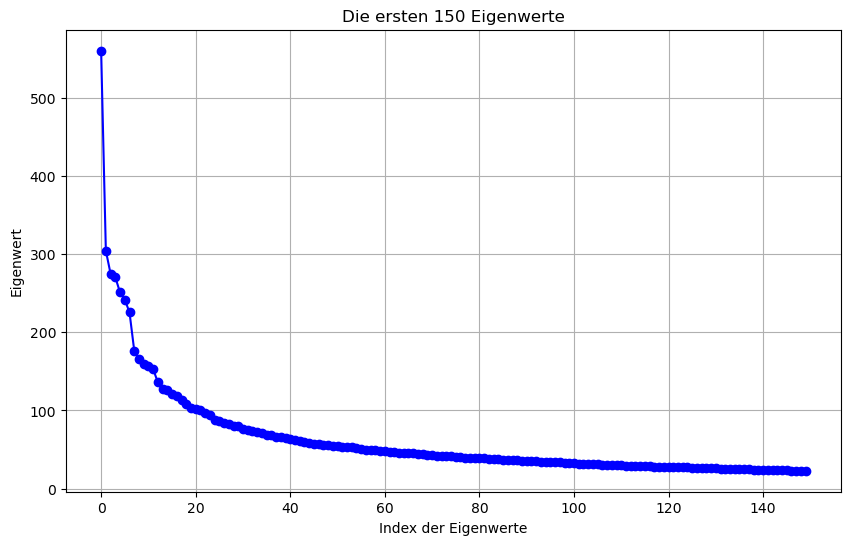

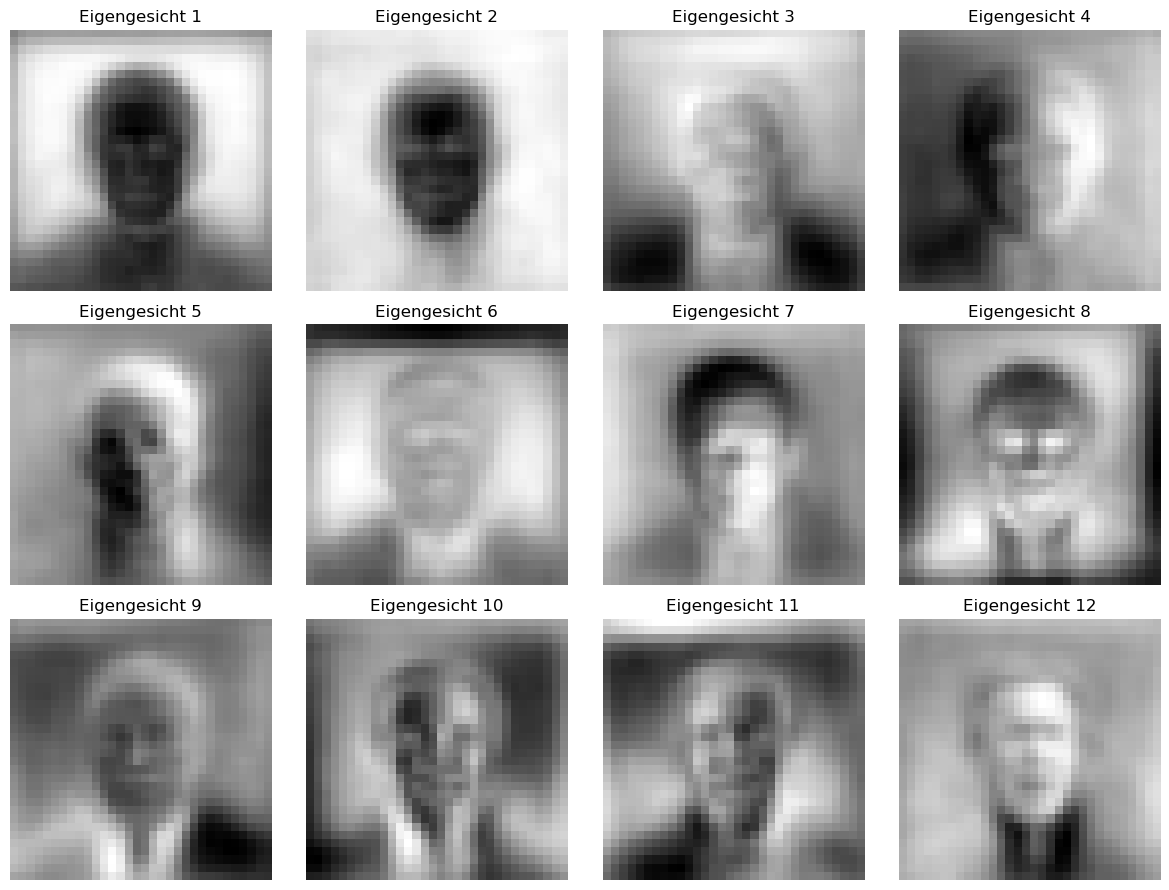

In [ ]:
import matplotlib.pyplot as plt

# PCA-Funktion
def pca(X, r):
    # Schritt 1: Zentrieren
    mean_X = np.mean(X, axis=0)
    centered_X = X - mean_X

    # Schritt 2: Normalisieren
    std_X = np.std(centered_X, axis=0)
    normalized_X = centered_X / std_X

    # Schritt 3/4: Singulärwertzerlegung
    U, D, VT = np.linalg.svd(normalized_X)

    # Schritt 5 + 6: Projizieren der Hauptvektoren auf Datenmatrix
    V = VT[:r, :].T
    UD = normalized_X.dot(V)

    # Schritt 7: Standardabweichung der Hauptkomponenten berechnen
    std_UD = np.std(UD, axis=0, ddof=1)

    # Alternativer Ansatz für Standardabweichung der Hauptkomponenten
    n = X.shape[0]
    std_UDv2 = D / pow((n - 1), 2)

    return U, D, VT, UD, std_UD, V, std_UDv2, mean_X


num_components = 150

U, D, VT, UD, std_UD, V, std_UDv2, mean_X = pca(normalized_images, num_components)

# Plot der ersten 150 Eigenwerte
plt.figure(figsize=(10, 6))
plt.plot(D[:150], marker='o', linestyle='-', color='b')
plt.title('Die ersten 150 Eigenwerte')
plt.xlabel('Index der Eigenwerte')
plt.ylabel('Eigenwert')
plt.grid()
plt.show()

# Darstellung der ersten 12 Eigengesichter
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.ravel()

for i in range(12):
    eig_face = V[:, i].reshape(32, 32)  # Rücktransformation in Bildformat
    axes[i].imshow(eig_face, cmap='gray')
    axes[i].set_title(f'Eigengesicht {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Interpretation:
# 

d) Erstellung von Abraham Lincoln Erkenner.

Projektion der Bilder auf die ersten 7 Eigengesichter
Berechnung des euklidischen Abstands dieses 7x7 Vekrorraumes und damit Bestimmung der am wahrscheinlichsten Person auf dem Bild.

In [ ]:


top_7_eigenvectors = normalized_images[:7, :]

num_components = 7
U, D, VT, UD, std_UD, V, std_UDv2, mean_X = pca(normalized_test_images, num_components)



# Schritt 1: Projizieren der Trainingsdaten in den 7-dimensionalen Merkmalsraum
projected_train_data = np.dot(normalized_images, top_7_eigenvectors.T)

# Projizieren der ersten 7 Testbilder in den 7-dimensionalen Merkmalsraum
projected_test_data = np.dot(normalized_test_images[:7, :], top_7_eigenvectors.T)

# Schritt 2: Berechne den euklidischen Abstand zwischen jedem projizierten Testbild und allen projizierten Trainingsbildern
distances = []

for test_vector in projected_test_data:
    # Berechnung euklidischer Abstand
    dists = np.linalg.norm(projected_train_data - test_vector, axis=1)
    distances.append(dists)

print('Euklidischer Abstand: ', distances)

# Kleinsten Eklidischen Abstand berechnen
for dists in distances:

    nearest_neighbors = np.argmin(dists)


# Überprüfen der Klassifikation
results = []
for i, nearest in enumerate(nearest_neighbors):
    test_label = person_test_names[i]
    predicted_label = person_names[nearest]
    is_correct = test_label == predicted_label
    results.append((i, test_label, predicted_label, is_correct))

# Ausgabe der Klassifikationsergebnisse
for result in results:
    test_index, true_label, predicted_label, correct = result
    status = "Korrekt" if correct else "Falsch"

results

Euklidischer Abstand:  [array([120.60854436, 109.29107281,  73.7950209 , ...,  85.89098534,
       149.65562694,  63.70136096]), array([284.50671771, 277.95924491, 124.11496678, ..., 252.19796581,
       319.81283927, 114.37415352]), array([191.95175396, 183.02075991,  41.73772934, ..., 158.29305584,
       225.32301544,  21.66881649]), array([146.94487829, 136.64609585,  50.57396936, ..., 113.05948174,
       179.33304411,  34.85663349]), array([ 62.16323462,  55.23506547, 210.0472538 , ...,  77.80050445,
        22.1153659 , 210.2263712 ]), array([311.83880865, 306.24094246, 151.77050338, ..., 281.00715785,
       348.79718021, 143.14751261]), array([174.21089021, 164.7360539 ,  33.09043036, ..., 138.67901522,
       206.32831412,   0.        ])]


[(0, 'Ariel_Sharon', 'Ariel_Sharon', True),
 (1, 'Colin_Powell', 'Colin_Powell', True),
 (2, 'Donald_Rumsfeld', 'Donald_Rumsfeld', True),
 (3, 'George_W_Bush', 'George_W_Bush', True),
 (4, 'Gerhard_Schroeder', 'Gerhard_Schroeder', True),
 (5, 'Hugo_Chavez', 'Hugo_Chavez', True),
 (6, 'Tony_Blair', 'Tony_Blair', True)]